# FAIR Universe - Weak Lensing ML Uncertainty Challenge
## Phase 1 Starting Kit: Convolutional Neural Network + MCMC
***

In the universe, massive objects like galaxies and clusters of galaxies bend the path of light traveling near them — a phenomenon known as gravitational lensing, as predicted by Einstein’s general relativity. When this bending is subtle, it’s known as weak gravitational lensing. It slightly distorts the shapes of distant galaxies as their light travels through the cosmic web of matter, including dark matter and ordinary matter (baryons), on its way to Earth.

By carefully measuring these tiny distortions across the sky, we can reconstruct convergence maps — essentially cosmic “heat maps” that show where matter is concentrated, even if that matter is invisible. These maps let us trace the hidden structure of the universe.

Crucially, weak lensing maps contain rich cosmological information. By statistically analyzing the patterns in these distortions, we can learn about the universe’s content and evolution. For example, we can estimate how much dark matter and dark energy exist, how fast the universe is expanding, and how structures have grown over time. In this way, weak lensing helps us constrain our cosmological model.

Currently, the most widely accepted model of the universe is called $\Lambda$CDM (Lambda Cold Dark Matter). It describes a universe dominated by dark energy (represented by the Greek letter $\Lambda$, or Lambda) and cold dark matter, with only a small fraction made up of normal matter like stars and planets. Weak lensing is one of the most powerful tools we have to test and refine this model.

The goal of this data challenge is to weak lensing convergence maps to constrain the physical parameters of ΛCDM model, $\Omega_m$, which describes what fraction of the universe’s total energy is made of matter (both normal and dark matter), and $S_8$, which measures of how “clumpy” the matter in the universe is on large scales.

***

#### ⚠️ NOTE:
In this notebook, we will utilize `PyTorch` to train convolutional neural networks for the Phase 1 task.
- If you are running this notebook on Google Colab, please navigate to **runtime** $\rightarrow$ **Change runtime type** and select a GPU resource for efficient training.
- If you are running this notebook on your local machine, you may need GPU resources for efficient training. Also, please make sure that you have installed all required libraries and relevant dependencies. Fore more information, see the `conda` directory of this repository.

`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB = 'google.colab' in str(get_ipython())

In [2]:
if COLAB:
    # clone github repo
    !git clone --depth 1 https://github.com/FAIR-Universe/Cosmology_Challenge.git
    # move to the HEP starting kit folder
    %cd Cosmology_Challenge/

# 0 - Imports & Settings

In [3]:
import os
import json
import time
import zipfile
import datetime
import warnings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1 - Helper Classes for
- Utitlity Functions
- Data Loading
- Visualizations
- Scoring Functions

### Utility

In [4]:
class Utility:
    @staticmethod
    def add_noise(data, mask, ng, pixel_size=2.):
        """
        Add noise to a noiseless convergence map.

        Parameters
        ----------
        data : np.array
            Noiseless convergence maps.
        mask : np.array
            Binary mask map.
        ng : float
            Number of galaxies per arcmin². This determines the noise level; a larger number means smaller noise.
        pixel_size : float, optional
            Pixel size in arcminutes (default is 2.0).
        """

        return data + np.random.randn(*data.shape) * 0.4 / (2*ng*pixel_size**2)**0.5 * mask
    
    @staticmethod
    def load_np(data_dir, file_name):
        file_path = os.path.join(data_dir, file_name)
        return np.load(file_path)

    @staticmethod
    def save_np(data_dir, file_name, data):
        file_path = os.path.join(data_dir, file_name)
        np.save(file_path, data)

    @staticmethod
    def save_json_zip(submission_dir, json_file_name, zip_file_name, data):
        """
        Save a dictionary with 'means' and 'errorbars' into a JSON file,
        then compress it into a ZIP file inside submission_dir.

        Parameters
        ----------
        submission_dir : str
            Path to the directory where the ZIP file will be saved.
        file_name : str
            Name of the ZIP file (without extension).
        data : dict
            Dictionary with keys 'means' and 'errorbars'.

        Returns
        -------
        str
            Path to the created ZIP file.
        """
        os.makedirs(submission_dir, exist_ok=True)

        json_path = os.path.join(submission_dir, json_file_name)

        # Save JSON file
        with open(json_path, "w") as f:
            json.dump(data, f)

        # Path to ZIP
        zip_path = os.path.join(submission_dir, zip_file_name)

        # Create ZIP containing only the JSON
        with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
            zf.write(json_path, arcname=json_file_name)

        # Remove the standalone JSON after zipping
        os.remove(json_path)

        return zip_path

### Data

In [5]:
class Data:
    def __init__(self, data_dir, USE_PUBLIC_DATASET):
        self.USE_PUBLIC_DATASET = USE_PUBLIC_DATASET
        self.data_dir = data_dir
        self.mask_file = 'WIDE12H_bin2_2arcmin_mask.npy'
        self.viz_label_file = 'label.npy'
        if self.USE_PUBLIC_DATASET:
            self.kappa_file = 'WIDE12H_bin2_2arcmin_kappa.npy'
            self.label_file = self.viz_label_file
            self.Ncosmo = 101  # Number of cosmologies in the entire training data
            self.Nsys = 256    # Number of systematic realizations in the entire training data
            self.test_kappa_file = 'WIDE12H_bin2_2arcmin_kappa_noisy_test.npy'
            self.Ntest = 4000  # Number of instances in the test data
        else:
            self.kappa_file = 'sampled_WIDE12H_bin2_2arcmin_kappa.npy'
            self.label_file = 'sampled_label.npy'
            self.Ncosmo = 3    # Number of cosmologies in the sampled training data
            self.Nsys = 30     # Number of systematic realizations in the sampled training data
            self.test_kappa_file = 'sampled_WIDE12H_bin2_2arcmin_kappa_noisy_test.npy'
            self.Ntest = 3     # Number of instances in the sampled test data
        
        self.shape = [1424,176] # dimensions of each map 
        self.pixelsize_arcmin = 2 # pixel size in arcmin
        self.pixelsize_radian = self.pixelsize_arcmin / 60 / 180 * np.pi # pixel size in radian
        self.ng = 30  # galaxy number density. This determines the noise level of the experiment. Do not change this number.

    def load_train_data(self):
        self.mask = Utility.load_np(data_dir=self.data_dir, file_name=self.mask_file) # A binary map that shows which parts of the sky are observed and which areas are blocked
        self.kappa = np.zeros((self.Ncosmo, self.Nsys, *self.shape), dtype=np.float16)
        self.kappa[:,:,self.mask] = Utility.load_np(data_dir=self.data_dir, file_name=self.kappa_file) # Training convergence maps
        self.label = Utility.load_np(data_dir=self.data_dir, file_name=self.label_file) # Training labels (cosmological and physical paramameters) of each training map
        self.viz_label = Utility.load_np(data_dir=self.data_dir, file_name=self.viz_label_file) # For visualization of parameter distributions

    def load_test_data(self):
        self.kappa_test = np.zeros((self.Ntest, *self.shape), dtype=np.float16)
        self.kappa_test[:,self.mask] = Utility.load_np(data_dir=self.data_dir, file_name=self.test_kappa_file) # Test noisy convergence maps

### Visualization

In [6]:
class Visualization:
    
    @staticmethod
    def plot_mask(mask):
        plt.figure(figsize=(30,100))
        plt.imshow(mask.T)
        plt.show()

    @staticmethod
    def plot_noiseless_training_convergence_map(kappa):
        plt.figure(figsize=(30,100))
        plt.imshow(kappa[0,0].T, vmin=-0.02, vmax=0.07)
        plt.show()

    @staticmethod
    def plot_noisy_training_convergence_map(kappa, mask, pixelsize_arcmin, ng):
        plt.figure(figsize=(30,100))
        plt.imshow(Utility.add_noise(kappa[0,0], mask, ng, pixelsize_arcmin).T, vmin=-0.02, vmax=0.07)
        plt.show()

    @staticmethod
    def plot_cosmological_parameters_OmegaM_S8(label):
        plt.scatter(label[:,0,0], label[:,0,1])
        plt.xlabel(r'$\Omega_m$')
        plt.ylabel(r'$S_8$')
        plt.show()

    @staticmethod
    def plot_baryonic_physics_parameters(label):
        plt.scatter(label[0,:,2], label[0,:,3])
        plt.xlabel(r'$T_{\mathrm{AGN}}$')
        plt.ylabel(r'$f_0$')
        plt.show()

    @staticmethod
    def plot_photometric_redshift_uncertainty_parameters(label):
        plt.hist(label[0,:,4], bins=20)
        plt.xlabel(r'$\Delta z$')
        plt.show()

### Scoring function

In [7]:
class Score:
    @staticmethod
    def _score_phase1(true_cosmo, infer_cosmo, errorbar):
        """
        Computes the log-likelihood score for Phase 1 based on predicted cosmological parameters.

        Parameters
        ----------
        true_cosmo : np.ndarray
            Array of true cosmological parameters (shape: [n_samples, n_params]).
        infer_cosmo : np.ndarray
            Array of inferred cosmological parameters from the model (same shape as true_cosmo).
        errorbar : np.ndarray
            Array of standard deviations (uncertainties) for each inferred parameter 
            (same shape as true_cosmo).

        Returns
        -------
        np.ndarray
            Array of scores for each sample (shape: [n_samples]).
        """
        
        sq_error = (true_cosmo - infer_cosmo)**2
        scale_factor = 1000  # This is a constant that scales the error term.
        score = - np.sum(sq_error / errorbar**2 + np.log(errorbar**2) + scale_factor * sq_error, 1)
        score = np.mean(score)
        if score >= -10**6: # Set a minimum of the score (to properly display on Codabench)
            return score
        else:
            return -10**6

# 2 - Load train and test data

The training maps are generated by $N_{\rm cosmo}$ cosmological models, each model contains $N_{\rm sys}$ realizations with different nuisance parameters. So the shape of the training maps kappa is $(N_{\rm cosmo}, N_{\rm sys}, 1424, 176)$. 

Each training map is associated with 5 parameters, so the shape of label is $(N_{\rm cosmo}, N_{\rm sys}, 5)$. The first two parameters are cosmological parameters $\Omega_m$ and $S_8$, while the rest three parameters are nuisance parameters that describe systematic effects and need to be marginalized in the data analysis (two of them describe baryonic effects and the last one describes photometric redshift uncertainties).

In [8]:
root_dir = os.getcwd()
print("Root directory is", root_dir)

Root directory is /global/u2/p/pw_chang/WL-Challenge


**Option 1: To quickly run through this starting kit:** You may set `USE_PUBLIC_DATASET = False` so that only a downsampled training data and test data will be loaded. In the downsampled training data, there are $N_{\rm cosmo}=3$ cosmological models and $N_{\rm sys}=30$ realizations of nuisance parameters. The downsampled test data contains $N_{\rm test}=3$ instances.

***

#### ⚠️ NOTE:
To make a valid submission and obtain a score on Codabench, **you will need to make your predictions using the entire test data set (4,000 instances). Use the Option 2 below to load the entire test data.**

***

**Option 2: To load the entire training data and test data:** Set `USE_PUBLIC_DATASET = True` and specify a path where you will save the downloaded public data from Codabench. In the entire training data, there are $N_{\rm cosmo}=101$ cosmological models and $N_{\rm sys}=256$ realizations of nuisance parameters. The entire test data contains $N_{\rm test}=4000$ instances.

In [10]:
USE_PUBLIC_DATASET = False

# USE_PUBLIC_DATASET = True
PUBLIC_DATA_DIR = '[DEFINE THE PATH OF SAVED PUBLIC DATA HERE]'  # This is only required when you set USE_PUBLIC_DATASET = True

In [10]:
if not USE_PUBLIC_DATASET:                                         # Testing this startking kit with a tiny sample of the training data (3, 30, 1424, 176)
    DATA_DIR = os.path.join(root_dir, 'input_data/')
else:                                                              # Training your model with all training data (101, 256, 1424, 176)
    DATA_DIR = PUBLIC_DATA_DIR    

### Load the train and test data

In [11]:
# Initialize Data class object
data_obj = Data(data_dir=DATA_DIR, USE_PUBLIC_DATASET=USE_PUBLIC_DATASET)

# Load train data
data_obj.load_train_data()

# Load test data
data_obj.load_test_data()

In [12]:
Ncosmo = data_obj.Ncosmo
Nsys = data_obj.Nsys

print(f'There are {Ncosmo} cosmological models, each has {Nsys} realizations of nuisance parameters in the training data.')

There are 101 cosmological models, each has 256 realizations of nuisance parameters in the training data.


In [13]:
print(f'Shape of the training data = {data_obj.kappa.shape}')
print(f'Shape of the mask = {data_obj.mask.shape}')
print(f'Shape of the training label = {data_obj.label.shape}')
print(f'Shape of the test data = {data_obj.kappa_test.shape}')

Shape of the training data = (101, 256, 1424, 176)
Shape of the mask = (1424, 176)
Shape of the training label = (101, 256, 5)
Shape of the test data = (4000, 1424, 176)


#### ⚠️ NOTE:
- The original training images are *noiseless* (without any pixel-level noise).
- The original test images is *noisy* (pixel-level noise with galaxy number density $n_g = 30~\text{arcmin}^{-2}$ and pixel size $=2$ arcmin has been added).

- **You will have to add pixel-level noise to the training data through the helper function** `Utility.add_noise`.
    
For example:
```python
    noisy_kappa = Utility.add_noise(data=data_obj.kappa.astype(np.float64), 
                                    mask=data_obj.mask, 
                                    ng=data_obj.ng, 
                                    pixel_size=data_obj.pixelsize_arcmin)
```

The shape of `noisy_kappa` will be the same as the shape of `data_obj.kappa`.

In [15]:
# Add the pixel-level noise to the training set (note that this may take some time and large memory)

np.random.seed(31415)  # Fix the random seed for reproducible results
noisy_kappa = Utility.add_noise(data=data_obj.kappa.astype(np.float64), 
                                mask=data_obj.mask, 
                                ng=data_obj.ng, 
                                pixel_size=data_obj.pixelsize_arcmin)

In [14]:
print(f'Shape of the noised data {noisy_kappa.shape}')

Shape of the noised data (101, 256, 1424, 176)


#### ⚠️ NOTE:

If you want to split your own training/validation sets to evaluate your model, we recommend splitting the original training data along `axis = 1` (the 256 realizations of nuisance parameters). This will ensure that there are no intrinsic correlations between the training and validation sets.

In [45]:
# Split the data into training and validation sets

NP_idx = np.arange(Nsys)  # The indices of Nsys nuisance parameter realizations
split_fraction = 0.2      # Set the fraction of data you want to split (between 0 and 1)
seed = 5566               # Define your random seed for reproducible results

train_NP_idx, val_NP_idx = train_test_split(NP_idx, test_size=split_fraction,
                                            random_state=seed)

noisy_kappa_train = noisy_kappa[:, train_NP_idx]      # shape = (Ncosmo, len(train_NP_idx), 1424, 176)
label_train = data_obj.label[:, train_NP_idx]         # shape = (Ncosmo, len(train_NP_idx), 5)
noisy_kappa_val = noisy_kappa[:, val_NP_idx]          # shape = (Ncosmo, len(val_NP_idx), 1424, 176)
label_val = data_obj.label[:, val_NP_idx]             # shape = (Ncosmo, len(val_NP_idx), 5)

Ntrain = label_train.shape[0]*label_train.shape[1]
Nval = label_val.shape[0]*label_val.shape[1]

In [24]:
print(f'Shape of the split training data = {noisy_kappa_train.shape}')
print(f'Shape of the split validation data = {noisy_kappa_val.shape}')

print(f'Shape of the split training labels = {label_train.shape}')
print(f'Shape of the split validation labels = {label_val.shape}')

Shape of the split training data = (101, 204, 1424, 176)
Shape of the split validation data = (101, 52, 1424, 176)
Shape of the split training labels = (101, 204, 5)
Shape of the split validation labels = (101, 52, 5)


In [35]:
# Save the split data and labels for future usage

Utility.save_np(data_dir=DATA_DIR, file_name="noisy_kappa_train.npy",data=noisy_kappa_train)
Utility.save_np(data_dir=DATA_DIR, file_name="label_train.npy",data=label_train)
Utility.save_np(data_dir=DATA_DIR, file_name="noisy_kappa_val.npy",data=noisy_kappa_val)
Utility.save_np(data_dir=DATA_DIR, file_name="label_val.npy",data=label_val)

In [16]:
# # Load the saved split data (if you saved it at DATA_DIR before)

# noisy_kappa_train = Utility.load_np(data_dir=DATA_DIR, file_name="noisy_kappa_train.npy")
# label_train = Utility.load_np(data_dir=DATA_DIR, file_name="label_train.npy")
# noisy_kappa_val = Utility.load_np(data_dir=DATA_DIR, file_name="noisy_kappa_val.npy")
# label_val = Utility.load_np(data_dir=DATA_DIR, file_name="label_val.npy")

# Ntrain = label_train.shape[0]*label_train.shape[1]
# Nval = label_val.shape[0]*label_val.shape[1]

In [17]:
# Reshape the data for CNN
X_train = noisy_kappa_train.reshape(Ntrain, *data_obj.shape)
X_val = noisy_kappa_val.reshape(Nval, *data_obj.shape)

# Here, we ignore the nuisance parameters and only keep the 2 cosmological parameters
y_train = label_train.reshape(Ntrain, 5)[:, :2]
y_val = label_val.reshape(Nval, 5)[:, :2]

In [26]:
print(f'Shape of the split training data = {X_train.shape}')
print(f'Shape of the split validation data = {X_val.shape}')

print(f'Shape of the split training labels = {y_train.shape}')
print(f'Shape of the split validation labels = {y_val.shape}')

Shape of the split training data = (20604, 1424, 176)
Shape of the split validation data = (5252, 1424, 176)
Shape of the split training labels = (20604, 2)
Shape of the split validation labels = (5252, 2)


# 3 - Visualization

### 2D training maps

survey mask: a binary map that shows which parts of the sky are observed (yellow) and which areas are blocked (purple)

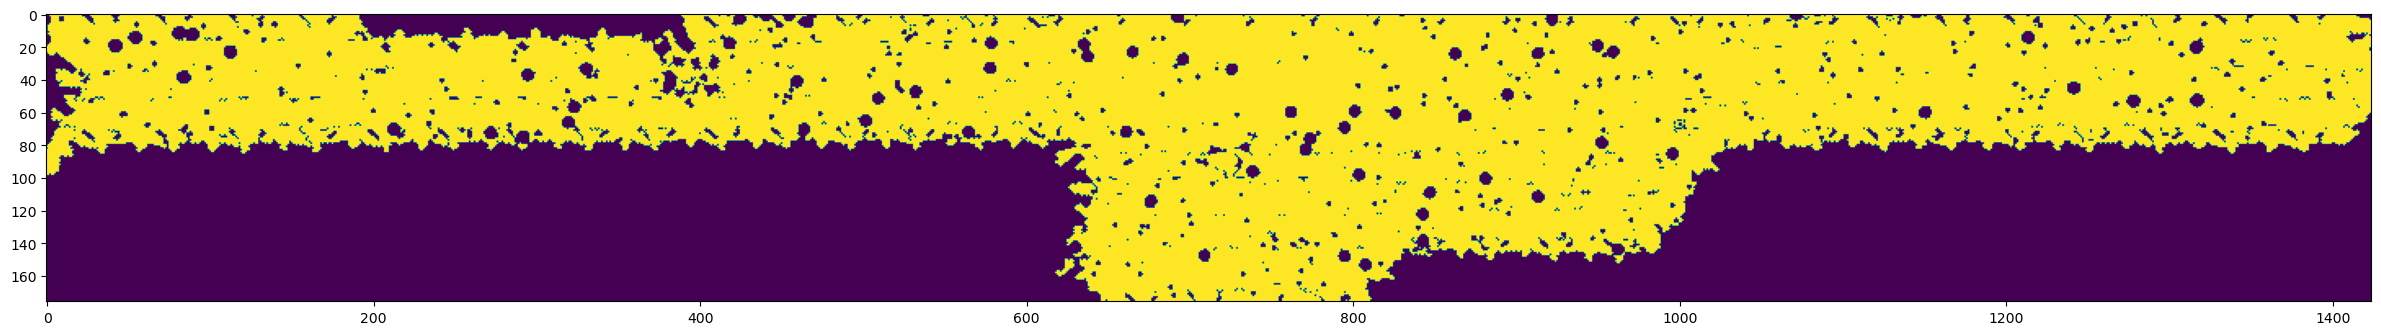

In [27]:
# mask
Visualization.plot_mask(mask=data_obj.mask)

noiseless training convergence map: The convergence maps show the projected matter density (including dark matter and ordinary matter) in the simulated universe, under the Born approximation. On large scales, we can see the matter forms web-like structures (cosmic web) in the universe. The dense regions in these maps, called dark matter halos, are the sites where galaxies form and reside.

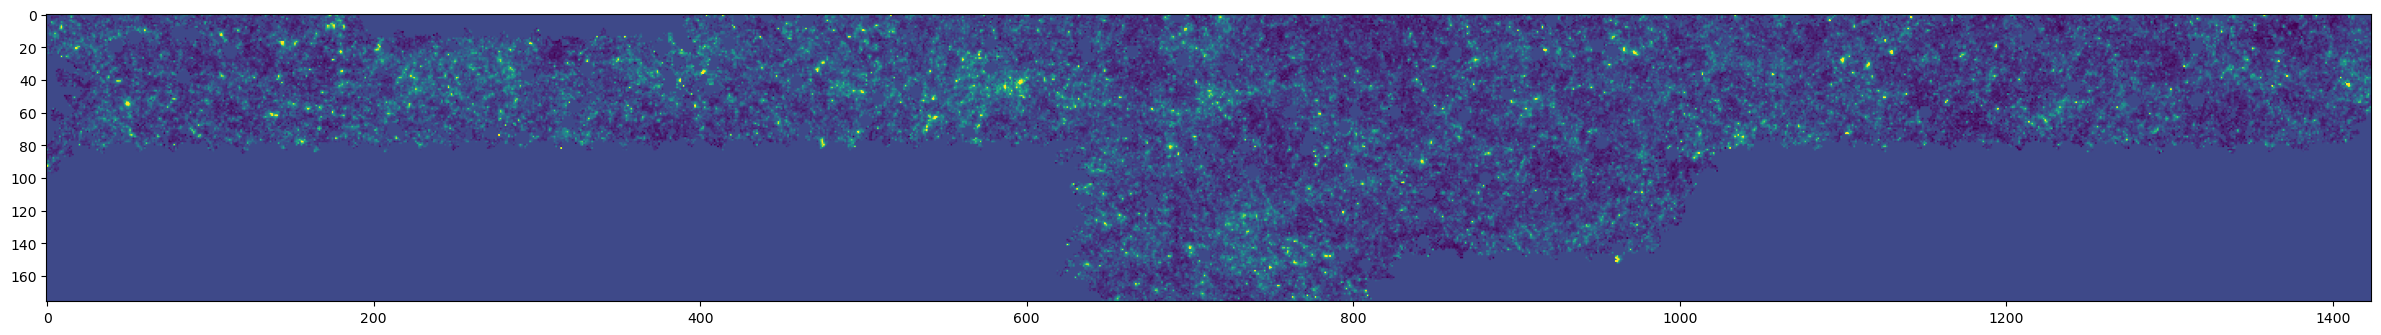

In [28]:
# noiseless training convergence map
Visualization.plot_noiseless_training_convergence_map(kappa=data_obj.kappa)

noisy training convergence map: We add Gaussian noise to the data. This mimics the observed data. During training the noise can be added on the fly with different realizations.

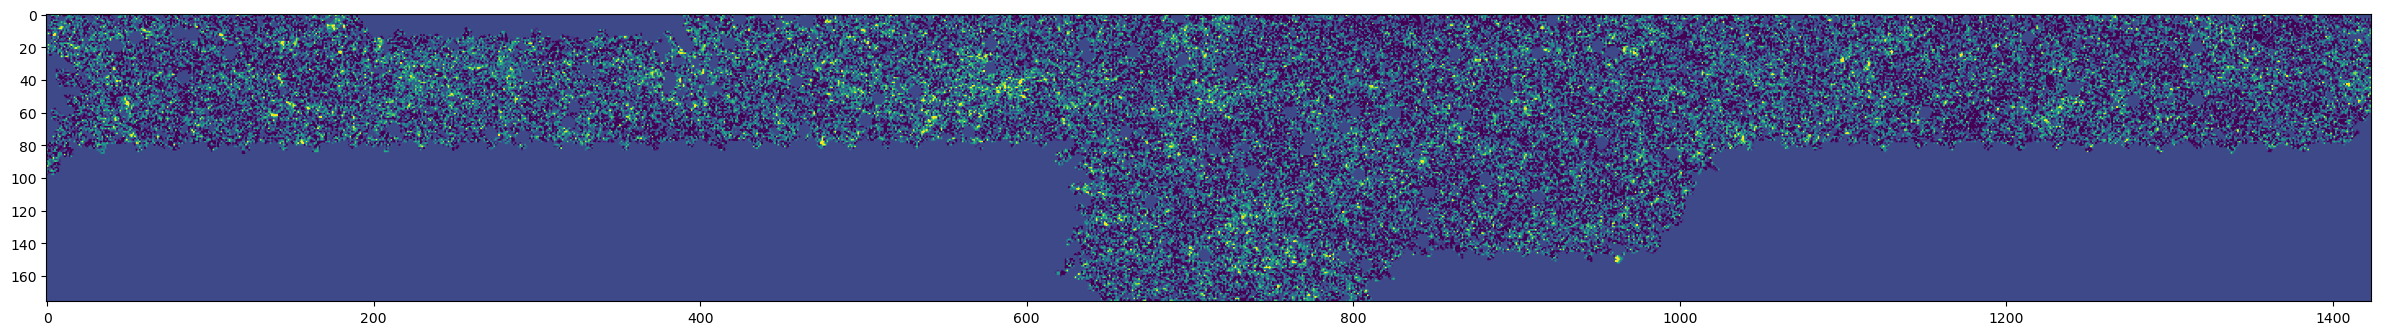

In [29]:
# noisy training convergence map
Visualization.plot_noisy_training_convergence_map(kappa=data_obj.kappa,
                                                  mask=data_obj.mask,
                                                  pixelsize_arcmin=data_obj.pixelsize_arcmin,
                                                  ng=data_obj.ng)

### Distribution of physical parameters

Distribution of cosmological parameters $\Omega_m$ and $S_8$. The density increases towards fiducial cosmology. Note that this distribution introduces a prior in the analysis. The test data cosmology follows the same distribution as the training data.

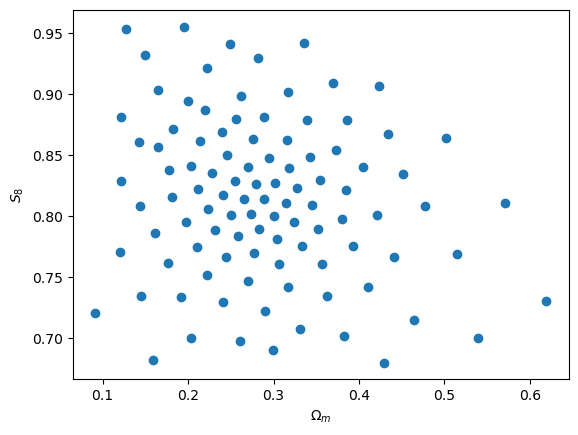

In [30]:
Visualization.plot_cosmological_parameters_OmegaM_S8(label=data_obj.viz_label)

Distribution of baryonic physics parameters. These are nuisance parameters and should be marginalized in the analysis. They follow a uniform distribution within the prior range $T_{\mathrm{AGN}} \in [7.2, 8.5]$, $f_0 \in [0, 0.0265]$

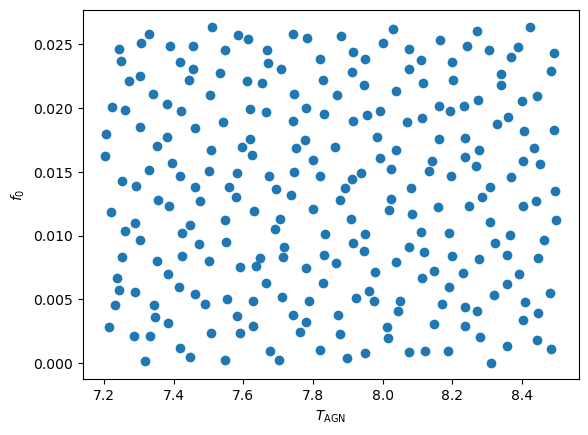

In [31]:
Visualization.plot_baryonic_physics_parameters(label=data_obj.viz_label)

Distribution of photometric redshift uncertainty parameters. This is a nuisance parameter and should be marginalized in the analysis. It follows a Gaussian distribution with mean 0 and std 0.022

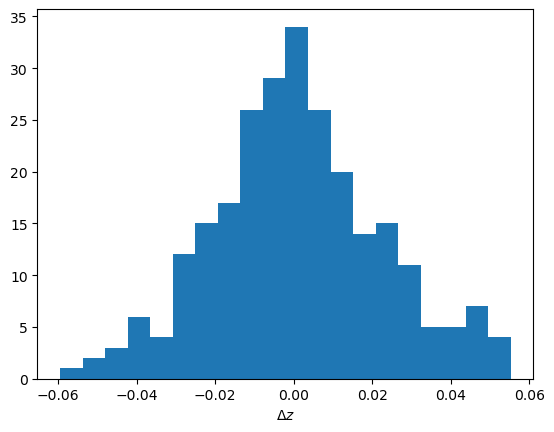

In [32]:
Visualization.plot_photometric_redshift_uncertainty_parameters(label=data_obj.viz_label)

# 4 - Training

In [33]:
# Define your path for saving the trained model
MODEL_SAVE_PATH = os.path.join(root_dir, "Phase1_starting_kit_CNN_MCMC_baseline.pth")

class Config:
    IMG_HEIGHT = data_obj.shape[0]
    IMG_WIDTH = data_obj.shape[1]
    
    # Parameters to predict (Omega_m, S_8)
    NUM_TARGETS = 2

    # Training hyperparameters
    BATCH_SIZE = 64
    EPOCHS = 15
    LEARNING_RATE = 2e-4
    WEIGHT_DECAY = 1e-4   # L2 regularization to prevent overfitting
    
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    MODEL_SAVE_PATH = MODEL_SAVE_PATH

In [34]:
# Simple CNN architecture for parameter estimation

class Simple_CNN(nn.Module):
    def __init__(self, height, width, num_targets):
        super(Simple_CNN, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self._feature_size = self._get_conv_output_size(height, width)
        
        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._feature_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_targets)
        )

    def _get_conv_output_size(self, height, width):
        dummy_input = torch.zeros(1, 1, height, width)
        output = self.conv_stack(dummy_input)
        return int(np.prod(output.size()))

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.fc_stack(x)
        return x

In [35]:
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, total=len(dataloader), desc="Training")
    for X, y in pbar:
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)


def validate_epoch(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    pbar = tqdm(dataloader, total=len(dataloader), desc="Validating")
    with torch.no_grad():
        for X, y in pbar:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total_loss += loss_fn(pred, y).item()
            
    return total_loss / len(dataloader)

In [36]:
class CosmologyDataset(Dataset):
    """
    Custom PyTorch Dataset
    """
    
    def __init__(self, data, labels=None,
                 transform=None,
                 label_transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].astype(np.float32)   # Convert from float16 to float32
        if self.transform:
            image = self.transform(image) 
        if self.labels is not None:
            label = self.labels[idx].astype(np.float32)
            label = torch.from_numpy(label)
            if self.label_transform:
                label = self.label_transform(label)
            return image, label
        else:
            return image

In [37]:
# Compute the means and stds of the training images (for standardizing the data)

means = np.mean(X_train, dtype=np.float32)
stds = np.std(X_train, dtype=np.float32)

In [38]:
# Image standardization
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor(),     
    transforms.Normalize(mean=[means], std=[stds]),   
])
print(f"Image stats (from train set): Mean={means}, Std={stds}")

# Label standardization
label_scaler = StandardScaler()
y_train_scaled = label_scaler.fit_transform(y_train)
y_val_scaled = label_scaler.transform(y_val)
print(f"Label stats (from train set): Mean={label_scaler.mean_}, Std={np.sqrt(label_scaler.var_)}")

Image stats (from train set): Mean=-0.00014721968909725547, Std=0.020474432036280632
Label stats (from train set): Mean=[0.29021683 0.81345297], Std=[0.1055216  0.06600116]


In [39]:
# Load the configuration
config = Config()
print(f"Using device: {config.DEVICE}")

# Create Datasets and DataLoaders
train_dataset = CosmologyDataset(
    data=X_train, 
    labels=y_train_scaled,
    transform=transform
)
val_dataset = CosmologyDataset(
    data=X_val, 
    labels=y_val_scaled,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

Using device: cuda


In [40]:
# Initialize the CNN model
model = Simple_CNN(config.IMG_HEIGHT,
                    config.IMG_WIDTH,
                    config.NUM_TARGETS).to(config.DEVICE)

Set `USE_PRETRAINED_MODEL = False` if you want to train a new model.\
Set `USE_PRETRAINED_MODEL = True` if you want to load a pretrained model.

In [47]:
USE_PRETRAINED_MODEL = False
# USE_PRETRAINED_MODEL = True

In [44]:
if not USE_PRETRAINED_MODEL:  
    # Train the model
    loss_fn = nn.MSELoss() 
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=config.LEARNING_RATE,
                                weight_decay=config.WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer,
                                  mode='min',
                                  factor=0.5,
                                  patience=5)
    # Training Loop
    best_val_loss = float('inf')
    start_time = time.time()
    for epoch in range(config.EPOCHS):
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, config.DEVICE)
        val_loss = validate_epoch(model, val_loader, loss_fn, config.DEVICE)
    
        scheduler.step(val_loss)    
        print(f"Epoch {epoch+1}/{config.EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
        
        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), config.MODEL_SAVE_PATH)
            print(f"  -> New best model saved to {config.MODEL_SAVE_PATH}")

    end_time = time.time()
    print(f"\nTraining finished in {(end_time - start_time)/60:.2f} minutes.")
    
    model.load_state_dict(torch.load(config.MODEL_SAVE_PATH, weights_only=True)) # Directly load the best model

else:
    # Check if the pretrained model exists
    if os.path.exists(config.MODEL_SAVE_PATH):
        # If the pretrained model exists, load the model
        model.load_state_dict(torch.load(config.MODEL_SAVE_PATH, weights_only=True))

    else:
        # If the pretrained model doesn't exist, show the warning message
        warning_msg = f"The path of pretrained model doesn't exist"
        warnings.warn(warning_msg)

Validating: 100%|██████████| 83/83 [00:03<00:00, 25.27it/s]


Epoch 1/15 | Train Loss: 0.598027 | Val Loss: 0.237245
  -> New best model saved to /global/u2/p/pw_chang/WL-Challenge/Phase1_starting_kit_CNN_MCMC_baseline.pth


Validating: 100%|██████████| 83/83 [00:02<00:00, 29.12it/s]


Epoch 2/15 | Train Loss: 0.201500 | Val Loss: 0.252975


Validating: 100%|██████████| 83/83 [00:03<00:00, 25.28it/s]


Epoch 3/15 | Train Loss: 0.156200 | Val Loss: 0.471727


Validating: 100%|██████████| 83/83 [00:02<00:00, 28.37it/s]


Epoch 4/15 | Train Loss: 0.140928 | Val Loss: 0.218861
  -> New best model saved to /global/u2/p/pw_chang/WL-Challenge/Phase1_starting_kit_CNN_MCMC_baseline.pth


Validating: 100%|██████████| 83/83 [00:02<00:00, 29.23it/s]


Epoch 5/15 | Train Loss: 0.116684 | Val Loss: 0.214827
  -> New best model saved to /global/u2/p/pw_chang/WL-Challenge/Phase1_starting_kit_CNN_MCMC_baseline.pth


Validating: 100%|██████████| 83/83 [00:02<00:00, 29.15it/s]


Epoch 6/15 | Train Loss: 0.108255 | Val Loss: 0.265236


Validating: 100%|██████████| 83/83 [00:02<00:00, 29.31it/s]


Epoch 7/15 | Train Loss: 0.104545 | Val Loss: 0.202362
  -> New best model saved to /global/u2/p/pw_chang/WL-Challenge/Phase1_starting_kit_CNN_MCMC_baseline.pth


Validating: 100%|██████████| 83/83 [00:02<00:00, 28.77it/s]


Epoch 8/15 | Train Loss: 0.095698 | Val Loss: 0.217140


Validating: 100%|██████████| 83/83 [00:02<00:00, 28.58it/s]


Epoch 9/15 | Train Loss: 0.087579 | Val Loss: 0.300654


Validating: 100%|██████████| 83/83 [00:03<00:00, 26.86it/s]


Epoch 10/15 | Train Loss: 0.088501 | Val Loss: 0.207917


Validating: 100%|██████████| 83/83 [00:02<00:00, 27.97it/s]


Epoch 11/15 | Train Loss: 0.079251 | Val Loss: 0.274757


Validating: 100%|██████████| 83/83 [00:02<00:00, 28.60it/s]


Epoch 12/15 | Train Loss: 0.082658 | Val Loss: 0.239793


Validating: 100%|██████████| 83/83 [00:03<00:00, 25.57it/s]


Epoch 13/15 | Train Loss: 0.073945 | Val Loss: 0.224601


Validating: 100%|██████████| 83/83 [00:02<00:00, 29.17it/s]


Epoch 14/15 | Train Loss: 0.064231 | Val Loss: 0.237653


Validating: 100%|██████████| 83/83 [00:03<00:00, 21.07it/s]


Epoch 15/15 | Train Loss: 0.060778 | Val Loss: 0.218686

Training finished in 6.11 minutes.


# 5 - Inference on the validation set

Similar to the power spectrum analysis, we can obtain the point estimates and their uncertainties by the sampled posterior distribution using MCMC. We have to calculate the mean summary statistics and covariance for $N_{\rm cosmo}$ cosmological models.

The mean summary statistics (descriptors) across the $N$ realizations for each of the $N_{\rm cosmo}$ cosmological models is
$$\mu(\boldsymbol{\theta}) \equiv \left\langle\boldsymbol{d}^{j}\right\rangle =\frac{1}{N} \sum_{j=1}^{N} \boldsymbol{d}^{j}~,$$
where $\boldsymbol{d}^{j}$ is the summary statistics of the $j$-th realizations of a given cosmological model.

The covariance matrix of the summary statistics, used later for parameter inference, is
$$\operatorname{Cov}(\boldsymbol{\theta})=\frac{1}{N-n_d-2} \sum_{j=1}^{N}~[\boldsymbol{d}^{j}-\mu(\boldsymbol{\theta})]^T ~[\boldsymbol{d}^{j}-\mu(\boldsymbol{\theta})],$$
where $n_d$ is the number of summary statistics.

The Gaussian likelihood of an observation (represented by summary statistics $\boldsymbol{d}$ given parameters $\boldsymbol{\theta}$ is:
$$
p(\boldsymbol{d}|\boldsymbol{\theta}) \propto \frac{1}{\sqrt{|{\rm Cov}(\boldsymbol{\theta})|}} \exp \left\{-\frac{1}{2}[\boldsymbol{d}-\mu(\boldsymbol{\theta})]^T {\rm Cov}^{-1}(\boldsymbol{\theta})[\boldsymbol{d}-\mu(\boldsymbol{\theta})]\right\}~.
$$

The log likelihood is thus:
$$
{\rm log}~ p(\boldsymbol{d}|\boldsymbol{\theta}) = -\frac{1}{2}{\rm log}~ |{\rm Cov}(\boldsymbol{\theta})|  -\frac{1}{2}[\boldsymbol{d}-\mu(\boldsymbol{\theta})]^T {\rm Cov}^{-1}(\boldsymbol{\theta})[\boldsymbol{d}-\mu(\boldsymbol{\theta})] + \text{(an offset of the normalization)}~.
$$

In this notebook, we use the outputs of the convolutional neural network (the point estimates of cosmological parameters $\boldsymbol{\theta} = (\hat{\Omega}_m, \hat{S}_8)$) as the summary statistic to constrain the cosmological parameters, so
$$
\boldsymbol{d} = f_{\rm NN}^{\phi} ~~\text{ with $n_d = 2$.}
$$

### Calculate the summary statistics $\boldsymbol{d}$ for all maps in the validation set

In [50]:
model.eval()
y_pred_list = []   
pbar = tqdm(val_loader, total=len(val_loader), desc="Validating")
with torch.no_grad():
    for X, _ in pbar:
        X = X.to(config.DEVICE)
        y_pred = model(X)        
        y_pred = label_scaler.inverse_transform(y_pred.cpu().numpy())
        y_pred_list.append(y_pred) 

y_pred_val = np.concatenate(y_pred_list, axis=0)

Validating: 100%|██████████| 83/83 [00:03<00:00, 22.77it/s]


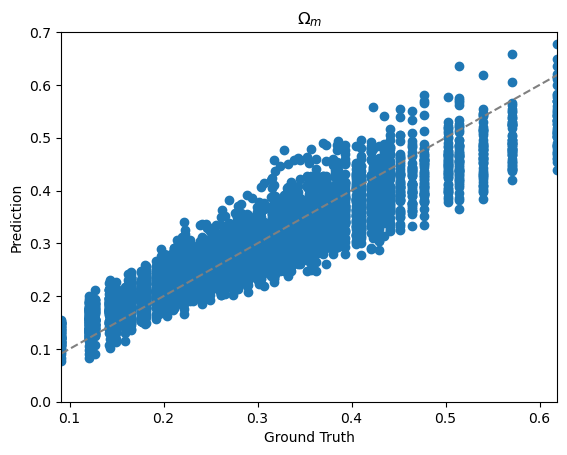

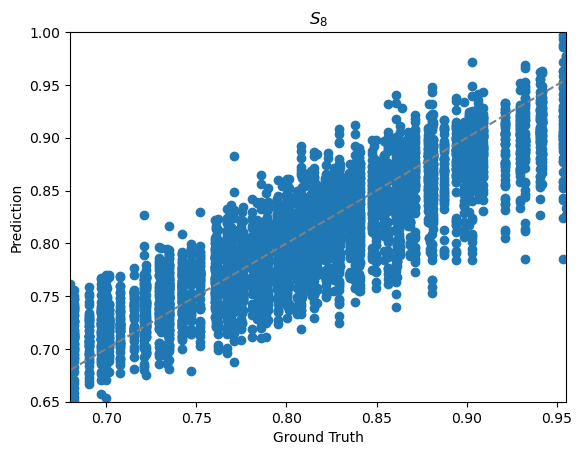

In [51]:
# Comparison of the CNN predictions and the validation labels

plt.scatter(y_val[:,0], y_pred_val[:,0])
plt.plot(sorted(y_val[:,0]), sorted(y_val[:,0]),
         color = 'grey', linestyle='dashed')
plt.xlim(np.min(y_val[:,0]), np.max(y_val[:,0]))
plt.ylim(0, 0.7)
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title(r'$\Omega_m$')
plt.show()

plt.scatter(y_val[:,1], y_pred_val[:,1])
plt.plot(sorted(y_val[:,1]), sorted(y_val[:,1]),
         color = 'grey', linestyle='dashed')
plt.xlim(np.min(y_val[:,1]), np.max(y_val[:,1]))
plt.ylim(0.65, 1)
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title(r'$S_8$')
plt.show()

### Mean summary statistics and covariance for $N_{\rm cosmo}$ cosmological model

In [52]:
# There are Ncosmo distinct cosmologies in the labels.
# Here we create a list that groups the indices of the validation instances with the same cosmological parameters

cosmology = data_obj.label[:,0,:2]   # shape = (Ncosmo, 2)

row_to_i = {tuple(cosmology[i]): i for i in range(Ncosmo)}
index_lists = [[] for _ in range(cosmology.shape[0])]

# Loop over each row in 'y_val' with shape = (Nval, 2)
for idx in range(len(y_val)):
    row_tuple = tuple(y_val[idx])
    i = row_to_i[row_tuple]
    index_lists[i].append(idx)

# val_cosmology_idx[i] = the indices idx of the validation examples with labels = cosmology[i]
val_cosmology_idx = [np.array(lst) for lst in index_lists]  

In [53]:
# The summary statistics of all realizations for all cosmologies in the validation set
d_vector = []  
n_d = 2   # Number of summary statistics for each map
for i in range(Ncosmo):
    d_i =  np.zeros((len(val_cosmology_idx[i]), n_d))  
    for j, idx in enumerate(val_cosmology_idx[i]):
        d_i[j] = y_pred_val[idx]

    d_vector.append(d_i)

In [54]:
# mean summary statistics (average over all realizations)
mean_d_vector = []
for i in range(Ncosmo):
    mean_d_vector.append(np.mean(d_vector[i], 0))
mean_d_vector = np.array(mean_d_vector)   

# covariance matrix
delta = []
for i in range(Ncosmo):
    delta.append((d_vector[i] - mean_d_vector[i].reshape(1, n_d))) 

cov_d_vector = [(delta[i].T @ delta[i] / (len(delta[i])-n_d-2))[None] for i in range(Ncosmo)]     
cov_d_vector = np.concatenate(cov_d_vector, 0) 

### Summary statistics emulator (linear interpolation between $N_{\rm cosmo}$ cosmological models)

In [55]:
from scipy.interpolate import LinearNDInterpolator
mean_d_vector_interp = LinearNDInterpolator(cosmology, mean_d_vector, fill_value=np.nan)
cov_d_vector_interp = LinearNDInterpolator(cosmology, cov_d_vector, fill_value=np.nan)

### Define prior, likelihood, posterior

In [56]:
logprior_interp = LinearNDInterpolator(cosmology, np.zeros((Ncosmo, 1)), fill_value=-np.inf)

# Note that the training data are not uniformly sampled, which introduces a prior distribution. Here we ignore that prior for simplicity.
# Also note that this prior would introduce bias for cosmologies at the boundary of the prior
def log_prior(x):
    logprior = logprior_interp(x).flatten()  # shape = (Ntest, ) 
    return logprior

# Gaussian likelihood with interpolated mean and covariance matrix
def loglike(x, d):
    mean = mean_d_vector_interp(x) 
    cov = cov_d_vector_interp(x)   
    delta = d - mean               
    
    inv_cov = np.linalg.inv(cov)
    cov_det = np.linalg.slogdet(cov)[1]
    
    return -0.5 * cov_det - 0.5 * np.einsum("ni,nij,nj->n", delta, inv_cov, delta)

def logp_posterior(x, d):
    logp = log_prior(x)
    select = np.isfinite(logp)
    if np.sum(select) > 0:
        logp[select] = logp[select] + loglike(x[select], d[select])
    return logp

### Quickly check the score on the validation set

In [57]:
# MCMC sampling to explore the posterior distribution

Nstep = 10000  # Number of MCMC steps (iterations)
sigma = 0.06   # Proposal standard deviation; should be tuned per method or parameter scale

# Randomly select initial points from the `cosmology` array for each test case
# Assumes `cosmology` has shape (Ncosmo, ndim) and `Ntest` is the number of independent chains/samples
current = cosmology[np.random.choice(Ncosmo, size=Nval)]

# Compute log-posterior at the initial points
curr_logprob = logp_posterior(current, y_pred_val)

# List to store sampled states (for all chains)
states = []

# Track total acceptance probabilities to compute acceptance rates
total_acc = np.zeros(len(current))

t = time.time()  # Track time for performance reporting

# MCMC loop
for i in range(Nstep):

    # Generate proposals by adding Gaussian noise to current state
    proposal = current + np.random.randn(*current.shape) * sigma    

    # Compute log-posterior at the proposed points
    proposal_logprob = logp_posterior(proposal, y_pred_val)

    # Compute log acceptance ratio (Metropolis-Hastings)
    acc_logprob = proposal_logprob - curr_logprob
    acc_logprob[acc_logprob > 0] = 0  # Cap at 0 to avoid exp overflow (acceptance prob ≤ 1)

    # Convert to acceptance probabilities
    acc_prob = np.exp(acc_logprob)

    # Decide whether to accept each proposal
    acc = np.random.uniform(size=len(current)) < acc_prob

    # Track acceptance probabilities (not binary outcomes)
    total_acc += acc_prob

    # Update states and log-probs where proposals are accepted
    current[acc] = proposal[acc]
    curr_logprob[acc] = proposal_logprob[acc]

    # Save a copy of the current state
    states.append(np.copy(current)[None])

    # Periodically print progress and acceptance rates
    if i % (0.1*Nstep) == 0.1*Nstep-1:
        print(
            'step:', len(states),
            'Time:', time.time() - t,
            'Min acceptance rate:', np.min(total_acc / (i + 1)),
            'Mean acceptance rate:', np.mean(total_acc / (i + 1))
        )
        t = time.time()  # Reset timer for next print interval

step: 1000 Time: 5.725066423416138 Min acceptance rate: 0.054792817217875954 Mean acceptance rate: 0.31643731762683813
step: 2000 Time: 5.844963312149048 Min acceptance rate: 0.05784810898748848 Mean acceptance rate: 0.3160636361518666
step: 3000 Time: 5.821455478668213 Min acceptance rate: 0.05757980485847652 Mean acceptance rate: 0.3159136870269113
step: 4000 Time: 5.83958888053894 Min acceptance rate: 0.0567045545311512 Mean acceptance rate: 0.3158475030505173
step: 5000 Time: 5.843663454055786 Min acceptance rate: 0.0573163356001728 Mean acceptance rate: 0.31580829502097424
step: 6000 Time: 5.851079702377319 Min acceptance rate: 0.05683592466997559 Mean acceptance rate: 0.31581057990775263
step: 7000 Time: 5.870632171630859 Min acceptance rate: 0.05935917447041534 Mean acceptance rate: 0.31575876812268544
step: 8000 Time: 5.897585391998291 Min acceptance rate: 0.06042488474113609 Mean acceptance rate: 0.3157787040221118
step: 9000 Time: 5.842806100845337 Min acceptance rate: 0.0599

In [58]:
# remove burn-in
states = np.concatenate(states[int(0.2*Nstep):], 0)

# mean and std of samples
mean_val = np.mean(states, 0)
errorbar_val = np.std(states, 0)

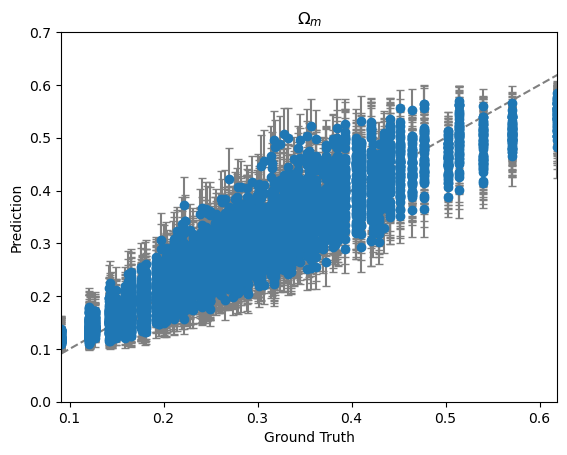

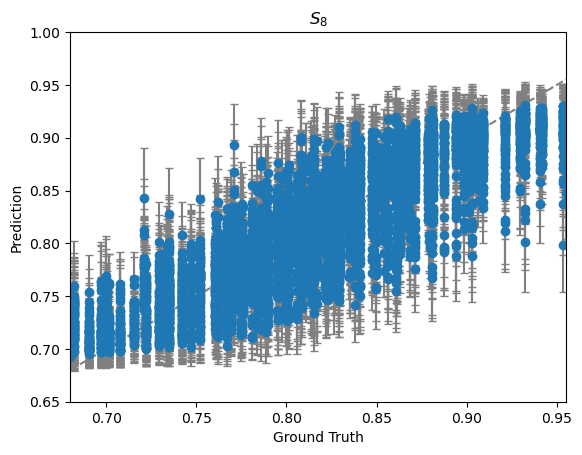

In [59]:
# Comparison of the means & standard deviations of the posterior distributions and the validation labels

plt.errorbar(y_val[:,0], mean_val[:,0], yerr=errorbar_val[:,0], 
             fmt='o', capsize=3, capthick=1, ecolor='grey')
plt.plot(sorted(y_val[:,0]), sorted(y_val[:,0]),
         color = 'grey', linestyle='dashed')
plt.xlim(np.min(y_val[:,0]), np.max(y_val[:,0]))
plt.ylim(0, 0.7)
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title(r'$\Omega_m$')
plt.show()

plt.errorbar(y_val[:,1], mean_val[:,1], yerr=errorbar_val[:,1], 
             fmt='o', capsize=3, capthick=1, ecolor='grey')
plt.plot(sorted(y_val[:,1]), sorted(y_val[:,1]),
         color = 'grey', linestyle='dashed')
plt.xlim(np.min(y_val[:,1]), np.max(y_val[:,1]))
plt.ylim(0.65, 1)
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title(r'$S_8$')
plt.show()

In [60]:
validation_score = Score._score_phase1(
    true_cosmo=y_val,
    infer_cosmo=mean_val,
    errorbar=errorbar_val
)
print('averaged score:', np.mean(validation_score))
print('averaged error bar:', np.mean(errorbar_val, 0))

averaged score: 8.60637401416431
averaged error bar: [0.04313719 0.03192223]


# 6 - Phase one inference

### Estimate the summary statistics $\boldsymbol{d}$ for all test data

In [61]:
test_dataset = CosmologyDataset(
    data=data_obj.kappa_test, 
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

In [62]:
model.eval()
y_pred_list = []   
pbar = tqdm(test_loader, total=len(test_loader), desc="Inference on the test set")
with torch.no_grad():
    for X in pbar:
        X = X.to(config.DEVICE)
        y_pred = model(X)        
        y_pred = label_scaler.inverse_transform(y_pred.cpu().numpy())
        y_pred_list.append(y_pred) 

y_pred_test = np.concatenate(y_pred_list, axis=0)

Inference on the test set: 100%|██████████| 63/63 [00:04<00:00, 12.65it/s]


### Sample the posterior!

In [63]:
# MCMC sampling to explore the posterior distribution

Nstep = 10000  # Number of MCMC steps (iterations)
sigma = 0.06   # Proposal standard deviation; should be tuned per method or parameter scale

# Randomly select initial points from the `cosmology` array for each test case
# Assumes `cosmology` has shape (Ncosmo, ndim) and `Ntest` is the number of independent chains/samples
current = cosmology[np.random.choice(Ncosmo, size=data_obj.Ntest)]

# Compute log-posterior at the initial points
curr_logprob = logp_posterior(current, y_pred_test)

# List to store sampled states (for all chains)
states = []

# Track total acceptance probabilities to compute acceptance rates
total_acc = np.zeros(len(current))

t = time.time()  # Track time for performance reporting

# MCMC loop
for i in range(Nstep):

    # Generate proposals by adding Gaussian noise to current state
    proposal = current + np.random.randn(*current.shape) * sigma    

    # Compute log-posterior at the proposed points
    proposal_logprob = logp_posterior(proposal, y_pred_test)

    # Compute log acceptance ratio (Metropolis-Hastings)
    acc_logprob = proposal_logprob - curr_logprob
    acc_logprob[acc_logprob > 0] = 0  # Cap at 0 to avoid exp overflow (acceptance prob ≤ 1)

    # Convert to acceptance probabilities
    acc_prob = np.exp(acc_logprob)

    # Decide whether to accept each proposal
    acc = np.random.uniform(size=len(current)) < acc_prob

    # Track acceptance probabilities (not binary outcomes)
    total_acc += acc_prob

    # Update states and log-probs where proposals are accepted
    current[acc] = proposal[acc]
    curr_logprob[acc] = proposal_logprob[acc]

    # Save a copy of the current state
    states.append(np.copy(current)[None])

    # Periodically print progress and acceptance rates
    if i % (0.1*Nstep) == 0.1*Nstep-1:
        print(
            'step:', len(states),
            'Time:', time.time() - t,
            'Min acceptance rate:', np.min(total_acc / (i + 1)),
            'Mean acceptance rate:', np.mean(total_acc / (i + 1))
        )
        t = time.time()  # Reset timer for next print interval

step: 1000 Time: 5.095174789428711 Min acceptance rate: 0.04117140672120754 Mean acceptance rate: 0.3143787252233658
step: 2000 Time: 5.72849178314209 Min acceptance rate: 0.03742729159492478 Mean acceptance rate: 0.31377707870547544
step: 3000 Time: 5.687513589859009 Min acceptance rate: 0.03521569249413473 Mean acceptance rate: 0.3137293015731946
step: 4000 Time: 5.651964426040649 Min acceptance rate: 0.03978831414021867 Mean acceptance rate: 0.313687121501074
step: 5000 Time: 5.682724237442017 Min acceptance rate: 0.037531157476569856 Mean acceptance rate: 0.3136541693533107
step: 6000 Time: 5.6522698402404785 Min acceptance rate: 0.03738894049533479 Mean acceptance rate: 0.313586113215853
step: 7000 Time: 5.691222906112671 Min acceptance rate: 0.0358396697416644 Mean acceptance rate: 0.31353581624636406
step: 8000 Time: 5.692092657089233 Min acceptance rate: 0.03419839870965085 Mean acceptance rate: 0.3135023738772881
step: 9000 Time: 5.703366041183472 Min acceptance rate: 0.034794

In [64]:
# remove burn-in
states = np.concatenate(states[int(0.2*Nstep):], 0)

# mean and std of samples
mean = np.mean(states, 0)
errorbar = np.std(states, 0)

#### ⚠️ NOTE:
- `mean`: a 2D array containing the point estimates of 2 cosmological parameters $\hat{\Omega}_m$ and $\hat{S}_8$.
- `errorbar`: a 2D array containing the one-standard deviation uncertainties of 2 cosmological parameters $\hat{\sigma}_{\Omega_m}$ and  $\hat{\sigma}_{S_8}$.
 
The shapes of `mean`, and `errorbar` must be $(N_{\rm test}, 2)$.

***

# 7 - (Optional) Prepare submission for Codabench

***

This section will save the model predictions `mean` and `errorbar` (both are 2D arrays with shape `(4000, 2)`, where `4000` is the number of test instances and `2` is the number of our parameters of interest) as a dictionary in a JSON file `result.json`. Then it will compress `result.json` into a zip file that can be directly submitted to Codabench.

***

In [66]:
data = {"means": mean.tolist(), "errorbars": errorbar.tolist()}
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
zip_file_name = 'Submission_' + the_date + '.zip'
zip_file = Utility.save_json_zip(
    submission_dir="submissions",
    json_file_name="result.json",
    zip_file_name=zip_file_name,
    data=data
)
print(f"Submission ZIP saved at: {zip_file}")

Submission ZIP saved at: submissions/Submission_25-09-08-23-39.zip
